In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
print('Pytorch version :', torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device : [{device}]')

Pytorch version : 1.7.1
device : [cuda:0]


In [2]:
from torchvision import datasets, transforms
train_data = datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=False)
test_data = datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=False)

In [3]:
BATCH_SIZE = 256
train_iter = DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE,num_workers=1)
test_iter = DataLoader(test_data,shuffle=True,batch_size=BATCH_SIZE,num_workers=1)

In [4]:
class LSTM(nn.Module):
    def __init__(self,x_dim=28,h_dim=256,y_dim=10 ):
        super(LSTM,self).__init__()
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.y_dim = y_dim
        # forget gate
        self.lin_xh_f = nn.Linear(self.x_dim,self.h_dim)
        self.conv = nn.Conv1d(in_channel=1,out_channels=1,kernel_size=3,padding=1)
        self.lin_hh_f = nn.Linear(self.h_dim,self.h_dim)
        # input gate
        self.lin_xh_in1 = nn.Linear(self.x_dim,self.h_dim)
        self.lin_hh_in1 = nn.Linear(self.h_dim,self.h_dim)
        self.lin_xh_in2 = nn.Linear(self.x_dim,self.h_dim)
        self.lin_hh_in2 = nn.Linear(self.h_dim,self.h_dim)
        # output gate
        self.lin_xh_out = nn.Linear(self.x_dim,self.h_dim)
        self.lin_hh_out = nn.Linear(self.h_dim,self.h_dim)        
        
        self.lin_out = nn.Linear(self.h_dim,self.y_dim)
        
        self.init_param()
    
    def forward(self,x):
        h_0 = torch.zeros(self.h_dim).to(device)
        c_0 = torch.zeros(self.h_dim).to(device)
        h_n = h_0
        c_n = c_0
        for i in range(self.x_dim):
            # forget
            input = x[:,i,:]
            a = self.lin_xh_f(input)
            b = self.lin_hh_f(h_n)
            forget_out = F.sigmoid(a+b)

            # input
            d = self.lin_xh_in1(input)
            e = self.lin_hh_in1(h_n)
            f = self.lin_xh_in2(input)
            g = self.lin_hh_in2(h_n)
            input_out = F.sigmoid(d+e)*F.tanh(f+g)

            # output
            h = self.lin_xh_out(input)
            i = self.lin_hh_out(h_n)
            output_out = F.sigmoid(h+i)
            
            # combine
            c_n = c_n*forget_out + input_out
            h_n = F.tanh(c_n)*output_out
        # result
        output = self.lin_out(h_n)
        return output
    
    def init_param(self):
        for name, param in self.named_modules():
            if 'lin' in name:
                nn.init.kaiming_normal_(param.weight)
                nn.init.zeros_(param.bias)

In [5]:
model = LSTM(x_dim=28,h_dim=256,y_dim=10,n_layer=3).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
loss = nn.CrossEntropyLoss()

In [6]:
count = 0
for name, param in model.named_parameters():
    number = param.view(-1).size(0)
    print(f'name: [{name}],param: [{param.view(-1)[:1]}],shape: [{param.shape}]')
    count += number
print(f'total = {count:,d}')

name: [lin_xh_f.weight],param: [tensor([0.1677], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256, 28])]
name: [lin_xh_f.bias],param: [tensor([0.], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256])]
name: [lin_hh_f.weight],param: [tensor([-0.0782], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256, 256])]
name: [lin_hh_f.bias],param: [tensor([0.], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256])]
name: [lin_xh_in1.weight],param: [tensor([-0.0873], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256, 28])]
name: [lin_xh_in1.bias],param: [tensor([0.], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256])]
name: [lin_hh_in1.weight],param: [tensor([0.0400], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256, 256])]
name: [lin_hh_in1.bias],param: [tensor([0.], device='cuda:0', grad_fn=<SliceBackward>)],shape: [torch.Size([256])]
name: [lin_xh_in2.weight],param: [tensor([0.

In [37]:
x = torch.rand(1,28,28).to(device)
y = model.forward(x)
y

tensor([[ 0.4942, -0.3823, -0.0638,  0.2566,  0.8910, -0.0693, -0.1671, -0.1555,
         -0.0944, -0.0112]], device='cuda:0', grad_fn=<AddmmBackward>)

In [46]:
def func_eval(model,data_iter,device):
    model.eval()
    total_num, count_num = 0,0
    for batch_in, batch_label in data_iter:
        input = batch_in.view(-1,28,28).to(device)
        y_pred = model.forward(input)
        _, y_ = torch.max(y_pred,dim=-1)
        count_num += (y_ == batch_label.to(device)).sum().item()
        total_num += batch_in.size(0)
    model.train()
    return count_num / total_num

In [50]:
func_eval(model,train_iter,device)

0.06955

In [53]:
print('train start')
EPOCHS = 10
model.train()
model.init_param()
print_num = 1
for i in range(EPOCHS):
    for batch_in, batch_label in train_iter:
        input = batch_in.view(-1,28,28).to(device)
        y_pred = model.forward(input)
        loss_out = loss(y_pred,batch_label.to(device))
        optimizer.zero_grad()
        loss_out.backward()
        optimizer.step()
    if (i%print_num) == 0:
        train_eval = func_eval(model,train_iter,device)
        test_eval = func_eval(model,test_iter,device)
        print(i, train_eval, test_eval, loss_out.data)

train start
0 0.9695333333333334 0.9656 tensor(0.1285, device='cuda:0')
1 0.9811 0.9745 tensor(0.1452, device='cuda:0')
2 0.987 0.9793 tensor(0.0491, device='cuda:0')
3 0.9873 0.9788 tensor(0.0620, device='cuda:0')
4 0.9926666666666667 0.9817 tensor(0.0064, device='cuda:0')
5 0.9915166666666667 0.9803 tensor(0.0632, device='cuda:0')
6 0.9960666666666667 0.9869 tensor(0.1019, device='cuda:0')
7 0.9957666666666667 0.9846 tensor(0.0650, device='cuda:0')
8 0.99695 0.9862 tensor(0.0051, device='cuda:0')
9 0.9950666666666667 0.9851 tensor(0.0021, device='cuda:0')


tensor([3, 6, 1, 8, 2, 0, 5, 1, 8, 3, 5, 7, 9, 8, 2, 2, 8, 2, 3, 6, 3, 7, 0, 4,
        4], device='cuda:0') tensor([3, 6, 1, 8, 2, 0, 5, 1, 8, 3, 5, 7, 9, 8, 2, 2, 8, 2, 3, 6, 3, 7, 0, 4,
        4])


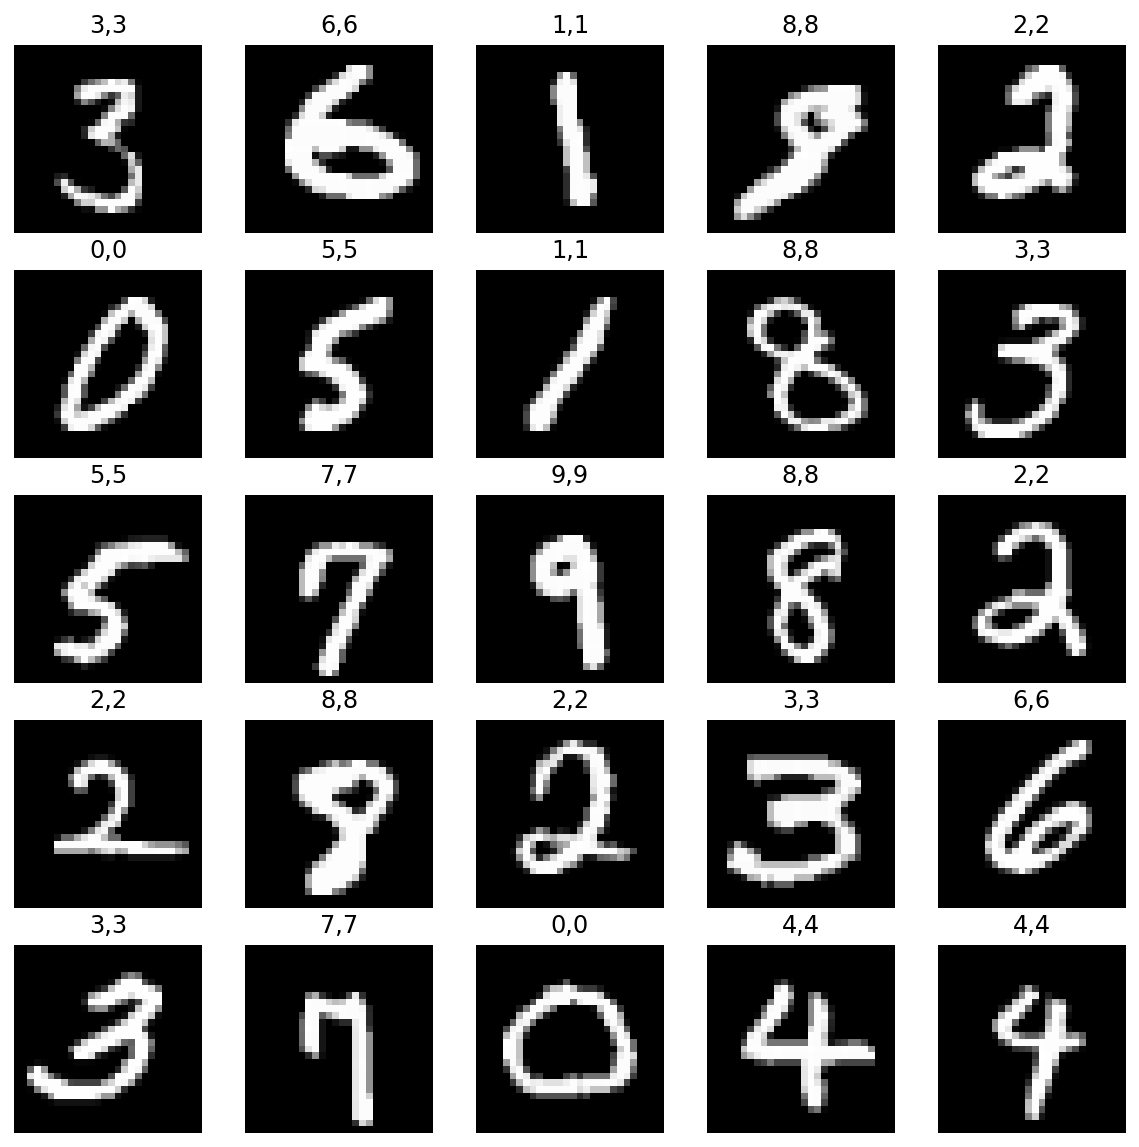

In [76]:
choice_num = 25
indices = np.random.choice(len(test_data),choice_num,replace=False)
test_x = test_data.data[indices]
test_y = test_data.targets[indices]
with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
print(y_pred, test_y)
plt.figure(figsize=(10,10))
for idx in range(choice_num):
    plt.subplot(5,5,idx+1)
    plt.imshow(test_x[idx],cmap='gray')
    plt.axis('off')
    plt.title(f'{test_y[idx]},{y_pred[idx]}')
plt.show()